In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading saved file
data=pd.read_csv('data-with-state-area.csv')
data['Rainfall'] = data['Rainfall'].apply(np.log1p)

In [3]:
data.head(5)

,id,BLat,BLon,ELat,ELon,Report Source,Magnitude,Injuries Direct/Indirect,Deaths Direct/Indirect,Event Narrative,Event,Episode Narrative,Rainfall,Windspeed,IsPropertyDamage,Bstate,Bcounty,Bcity,StateArea
0,0,43.49,-93.35,43.49,-93.35,Trained Spotter,1.25 in.,0/0,"0/0 (fatality details below, when available...)",NaN,Hail,A surface low pressure tracked east across Iow...,1.862529,46.8800,1,Iowa,Worth County,Northwood,56271.0
1,1,43.41,-93.27,43.41,-93.27,Trained Spotter,57 kts.,0/0,"0/0 (fatality details below, when available...)",NaN,Thunderstorm Wind,A surface low pressure tracked east across Iow...,2.357073,10.7600,1,Iowa,Worth County,Northwood,56271.0
2,2,43.50,-93.73,43.50,-93.73,Public,2.75 in.,0/0,"0/0 (fatality details below, when available...)",NaN,Hail,A surface low pressure tracked east across Iow...,2.571849,1.7728,1,Iowa,Winnebago County,Lake Mills,56271.0
3,3,41.54,-93.07,41.54,-93.07,Trained Spotter,0.88 in.,0/0,"0/0 (fatality details below, when available...)",NaN,Hail,A cold front dropped southeast through Iowa du...,0.530628,4.0400,1,Iowa,Jasper County,Monroe,56271.0
4,4,41.76,-92.70,41.76,-92.70,Trained Spotter,0.75 in.,0/0,"0/0 (fatality details below, when available...)",NaN,Hail,A cold front dropped southeast through Iowa du...,0.058269,0.7750,0,Iowa,Poweshiek County,Grinnell,56271.0


In [4]:
#Statewise events
State_event_df = data.groupby('Bstate')['Event'].value_counts().unstack(level=-1)
State_event_df = State_event_df.fillna(0)

In [5]:
#State Damage Rate
State_damageRate_df = data.groupby('Bstate')['IsPropertyDamage'].value_counts().unstack(level=-1)
State_damageRate_df = State_damageRate_df.fillna(0)

In [6]:
State_rainfall=data.groupby('Bstate')['Rainfall'].mean()
State_area = data.groupby('Bstate')['StateArea'].median()

In [7]:
State_df = State_damageRate_df.join(State_event_df)
State_df = State_df.join(State_rainfall)
State_df = State_df.join(State_area)
State_df = State_df.dropna()
State_df = State_df.reset_index().rename(columns={State_df.index.name:'STATE_NAME'})

In [8]:
State_df['Damage(%)']=(State_df[1]/(State_df[0]+State_df[1])*100)
State_df['Events_per_sqmile'] = (State_df[0]+State_df[1])/State_df['StateArea']

In [9]:
#Reading Shapefile
usa = gpd.read_file('states.shp')

In [10]:
State = State_df.set_index('STATE_NAME').join(usa.set_index('STATE_NAME'))
State=gpd.GeoDataFrame(State)
State['coords'] = State['geometry'].apply(lambda x: x.representative_point().coords[:])
State['coords'] = [coords[0] for coords in State['coords']]

In [13]:
#Creating Choropleth Maps
def choroplethMap(col,title,cmap='GnBu',figsize=(20,10)):
    '''
    This function creates choropleth map of input feature
    Inpute Parameters:
        col:Feature Name from dataframe to plot choropleth map
        title:  Title of choropleth map 
        cmap: (Optional) Color map Default:'GnBu'
        figsize: (Optional) figure size Default:(20,10)
    Returns:
        Choropleth Map
    '''
    fig, ax = plt.subplots(figsize=figsize)
    State.plot(column=col,ax=ax, cmap=cmap, edgecolor='black',linewidth=0.5)
    for idx, row in State.iterrows():
        plt.annotate(text=row['STATE_ABBR'], xy=row['coords'], horizontalalignment='center',size=8)
    ax.set_title(title, fontsize=16)
    ax.set_axis_off()
    # Create colorbar    
    vmin = State[col].min()
    vmax = State[col].max()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    fig.colorbar(sm)

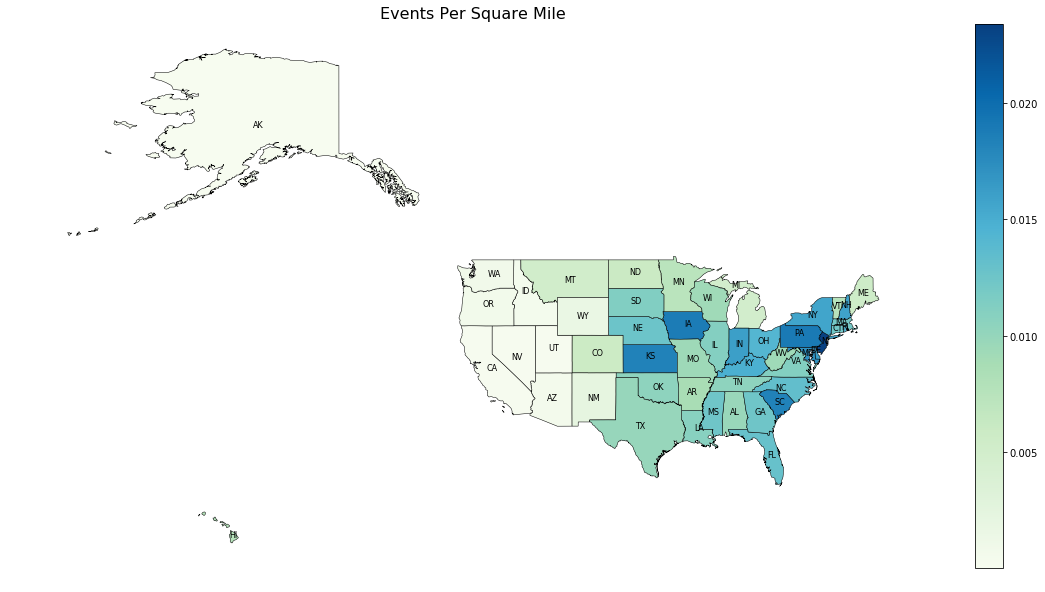

In [14]:
choroplethMap(col = 'Events_per_sqmile',title = "Events Per Square Mile")

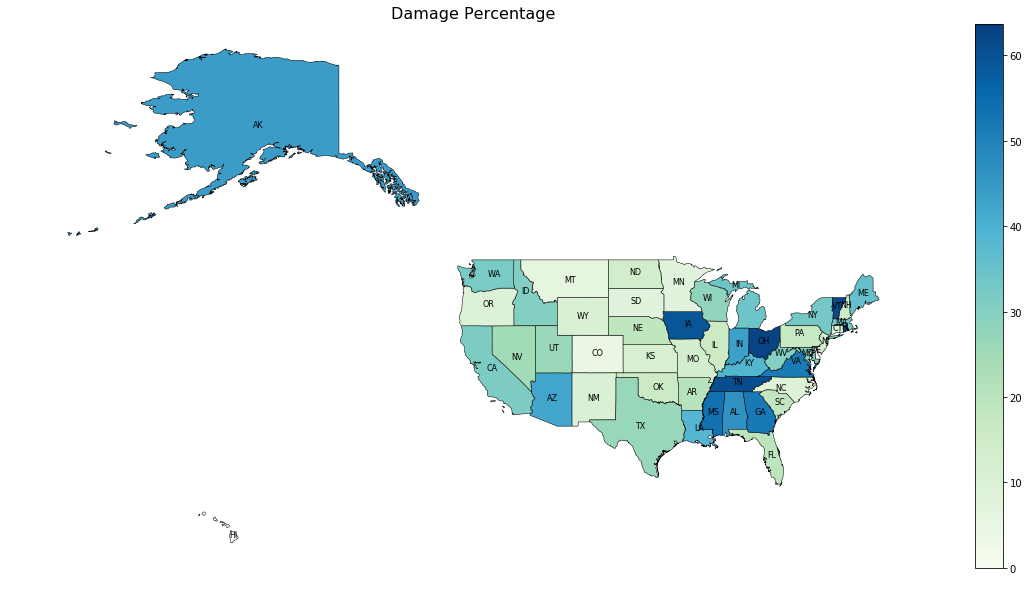

In [15]:
choroplethMap(col = 'Damage(%)',title = 'Damage Percentage')

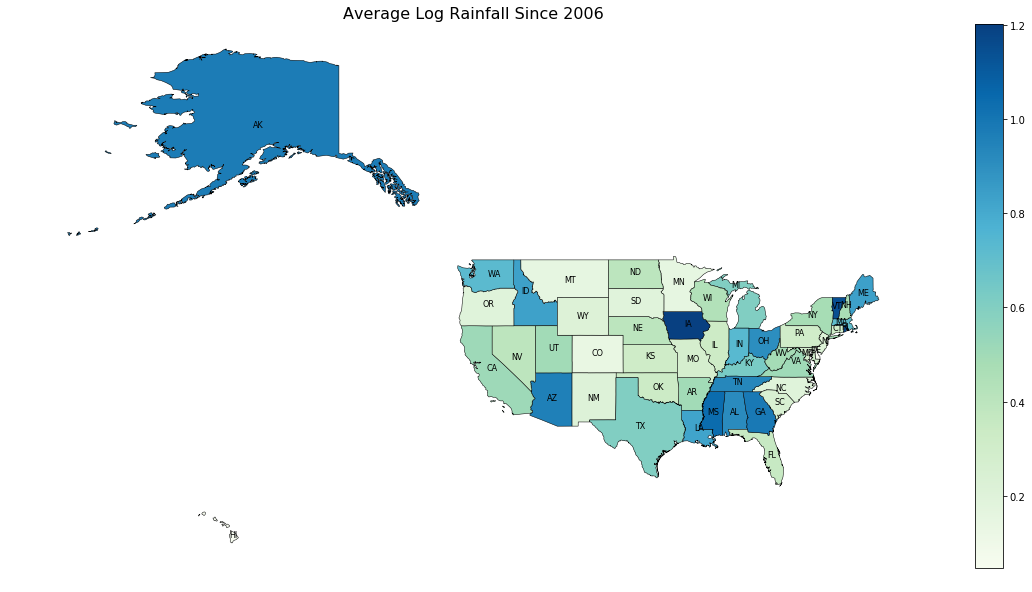

In [16]:
choroplethMap(col = 'Rainfall',title = 'Average Log Rainfall Since 2006')